In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import yfinance as yf
import seaborn as sns
sns.set(style='darkgrid')
from kneed import KneeLocator

import sys
sys.path.append('../src') 
from utils import stock_trading_strategy, stock_trading_strategy_supp_resist, plot_trading_strategy, download_stock_df, user_function, plot_candlestick

In [2]:
def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # knee = KneeLocator(range(1, size), wcss, curve='convex', direction='decreasing')
    # optimum_k = knee.knee

    # print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

In [3]:
from dateutil.relativedelta import relativedelta
from math import ceil, floor

def test_option_trading(stock_name,
                        start=(datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'),
                        end=datetime.today().strftime('%Y-%m-%d')
                       ):
    df = yf.download(stock_name.upper(), start=start, end=end)
                     
    df = df.reset_index()
    
    print(datetime.today().strftime('%Y-%m-%d'))

    low_clusters = get_optimum_clusters(df[(df['Low']!=df['Open'])&(df['Low']!=df['Close'])][['Date',"Low"]].set_index('Date'))
    # low_clusters = get_optimum_clusters(df[['Date',"Low"]].set_index('Date'))
    low_centers = low_clusters.cluster_centers_
    low_centers = np.sort(low_centers, axis=0)

    high_clusters = get_optimum_clusters(df[(df['High']!=df['Open'])&(df['High']!=df['Close'])][['Date',"High"]].set_index('Date'))
    # high_clusters = get_optimum_clusters(df[['Date',"High"]].set_index('Date'))
    high_centers = high_clusters.cluster_centers_
    high_centers = np.sort(high_centers, axis=0)
    
    close = df.iloc[-1]['Close']
    try: 
        support = max([e[0] for e in low_centers if e < close])
    except:
        print('Break all support; record min stock price')
        support = df['Low'].min()
    try:
        resistance = min([e[0] for e in high_centers if e > close])
    except:
        print('Break all resistance; record max stock price')
        resistance = df['High'].max()

    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    
    # Calculate upper and lower bands
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    close = df.iloc[-1]['Close']
    print('* previous stock price closing', round(close,2), '~ up', ceil(resistance*100)/100.0, ', down', floor(support*100)/100)
    print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])
    print("Latest Lower Bollinger Band:", df['Lower Band'].tolist()[-1])
    print("Latest Higher Bollinger Band:", df['Upper Band'].tolist()[-1])
        
    print(low_centers)
    print(high_centers)

    ax = plot_candlestick(df, figsize=(32,8))
    ax.set_title(stock_name)
    for low in low_centers[:]:
        ax.axhline(low[0], color='green', ls='--')

    for high in high_centers[:]:
        ax.axhline(high[0], color='red', ls='--')
    # df['5_MA'] = df['Close'].rolling(window=5).mean()
    # df['9_MA'] = df['Close'].rolling(window=9).mean()
    # df['20_MA'] = df['Close'].rolling(window=20).mean()
    # df['50_MA'] = df['Close'].rolling(window=50).mean()

    # ax.plot(df['Date'], df['Close'], color='black')
    # ax.plot(df['Date'], df['5_MA'], ls='--')

    # ax.plot(df['Date'], df['9_MA'], ls='--')
    # ax.plot(df['Date'], df['20_MA'], ls='--')
    # ax.plot(df['Date'], df['50_MA'], ls='--')
    ax.plot(df['Date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
    ax.plot(df['Date'], df['Upper Band'], ls='--', label='Upper Bollinger Band')
    ax.plot(df['Date'], df['Lower Band'], ls='--', label='Lower Bollinger Band')
    ax.fill_between(df['Date'], df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3) # Fill the area between the bands


## Test effectiveness of support and resistance in option trading

### Strategy 1:
* Touch support: long call
* Touch resistance: long put

#### Fail

### Strategy 2:

* Touch support
    * reflect: long call
    * break: long put
* Touch resistance:
    * reflect: long put
    * break: long call
    
#### Key question: how to confirm break / reflect?

* Base assumption: assume the support and resistance to hold, unless strong conflict signal observed.
* Assumption1.1: when going down, a short red line / long green line confirm reflect; long red line confirm break
* Assumption1.2: when going up, a short green line / long red line confirm reflect; long green line confirm break
* ~~Read from 1-min Candlestick~~ -- not applicable
* Check if trend is align with QQQ/SPY


#### Stop revenue needed; for conservative, start with 20%.

#### Precision of level should be relative to the stock price.

#### Hard to validate/'

### Strategy 3: 

* Touch support / resistance: check with the daily price range, 95% confidence

QQQ & TQQQ

[*********************100%%**********************]  1 of 1 completed
2024-04-13
* previous stock price closing 438.27 ~ up 438.76 , down 437.57
Latest 20 Day MA: 441.58600158691405
Latest Lower Bollinger Band: 434.33969495399356
Latest Higher Bollinger Band: 448.83230821983454
[[317.37912916]
 [332.90222168]
 [349.68349915]
 [358.65741951]
 [366.61333381]
 [374.99499839]
 [386.91454523]
 [404.19608605]
 [423.29789493]
 [437.57699738]]
[[321.73208491]
 [336.72285679]
 [356.61900126]
 [367.8753323 ]
 [376.39878799]
 [388.45642962]
 [407.68719971]
 [427.41764562]
 [438.75727289]
 [445.75000153]]


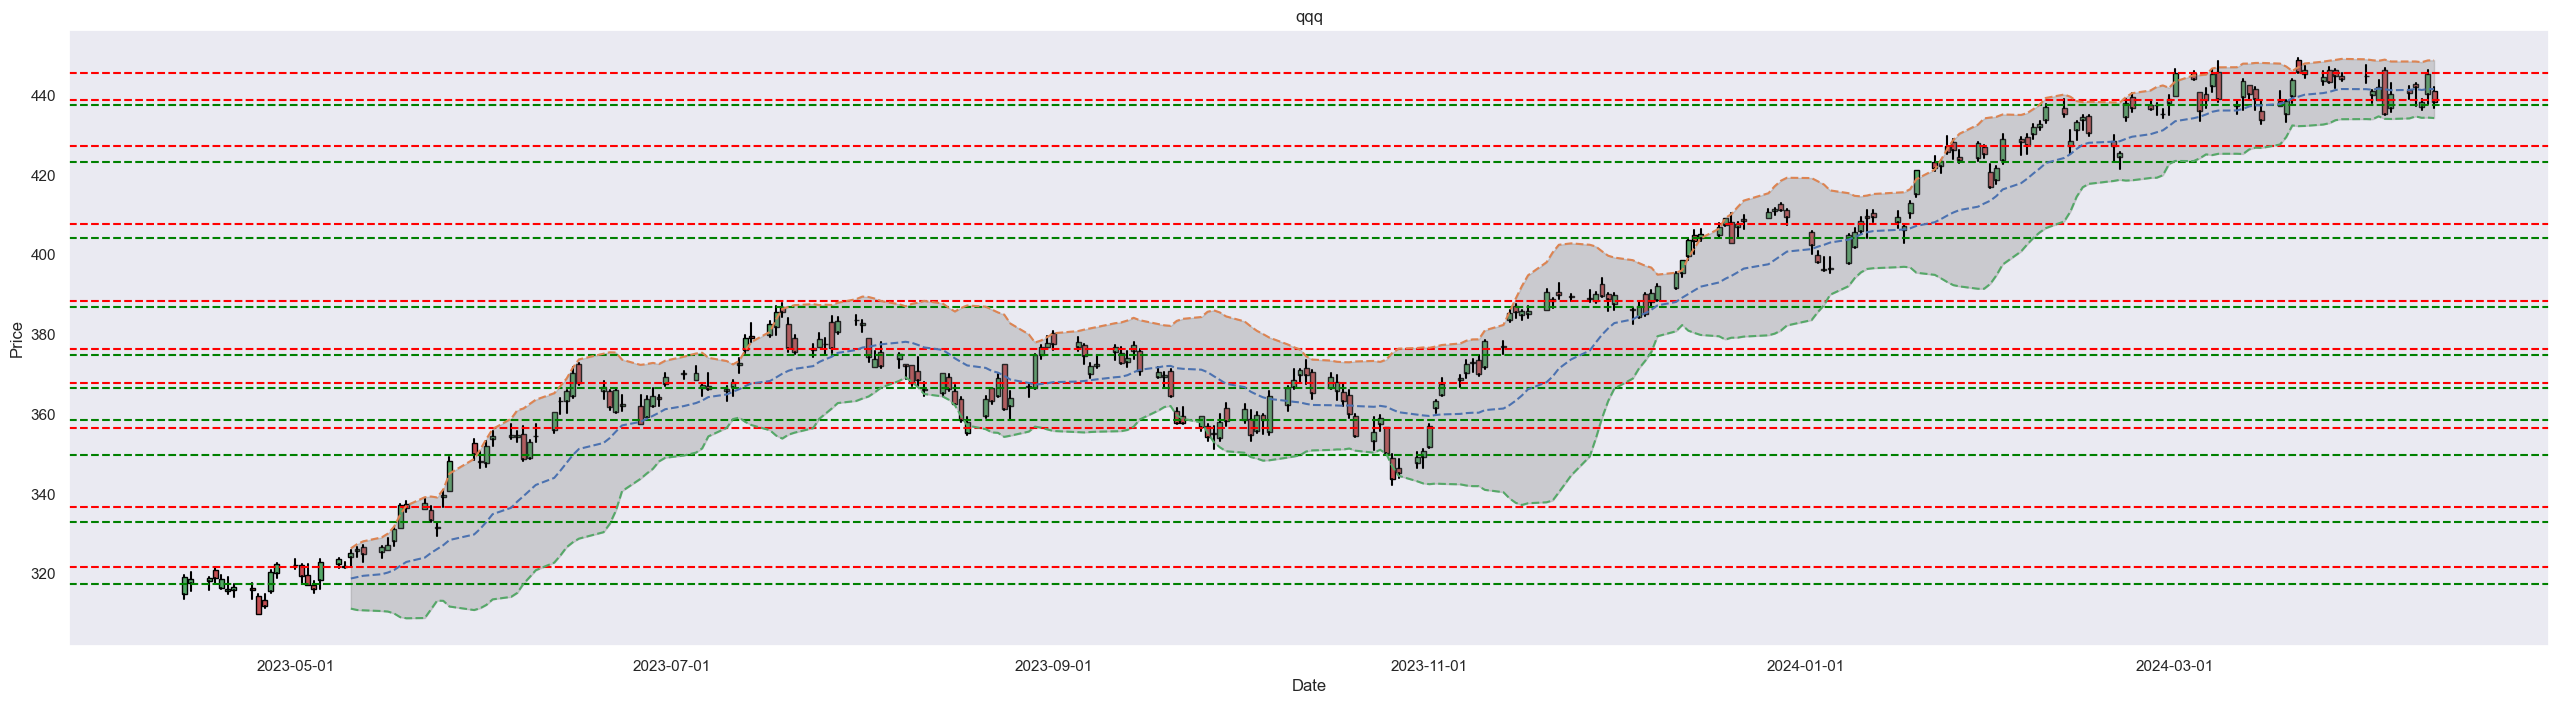

In [4]:
test_option_trading('qqq')

[*********************100%%**********************]  1 of 1 completed
2024-04-13
* previous stock price closing 58.72 ~ up 60.1 , down 58.5
Latest 20 Day MA: 60.55200023651123
Latest Lower Bollinger Band: 57.5570241055387
Latest Higher Bollinger Band: 63.546976367483765
[[27.16199997]
 [31.63846207]
 [35.25468755]
 [38.42045446]
 [41.56257139]
 [44.44772738]
 [49.11499996]
 [54.62187457]
 [58.50687528]
 [61.25545467]]
[[28.07291675]
 [32.09454536]
 [36.42032242]
 [39.61809494]
 [42.40705883]
 [45.41620675]
 [50.55952381]
 [56.54937434]
 [60.09958267]
 [62.6522221 ]]


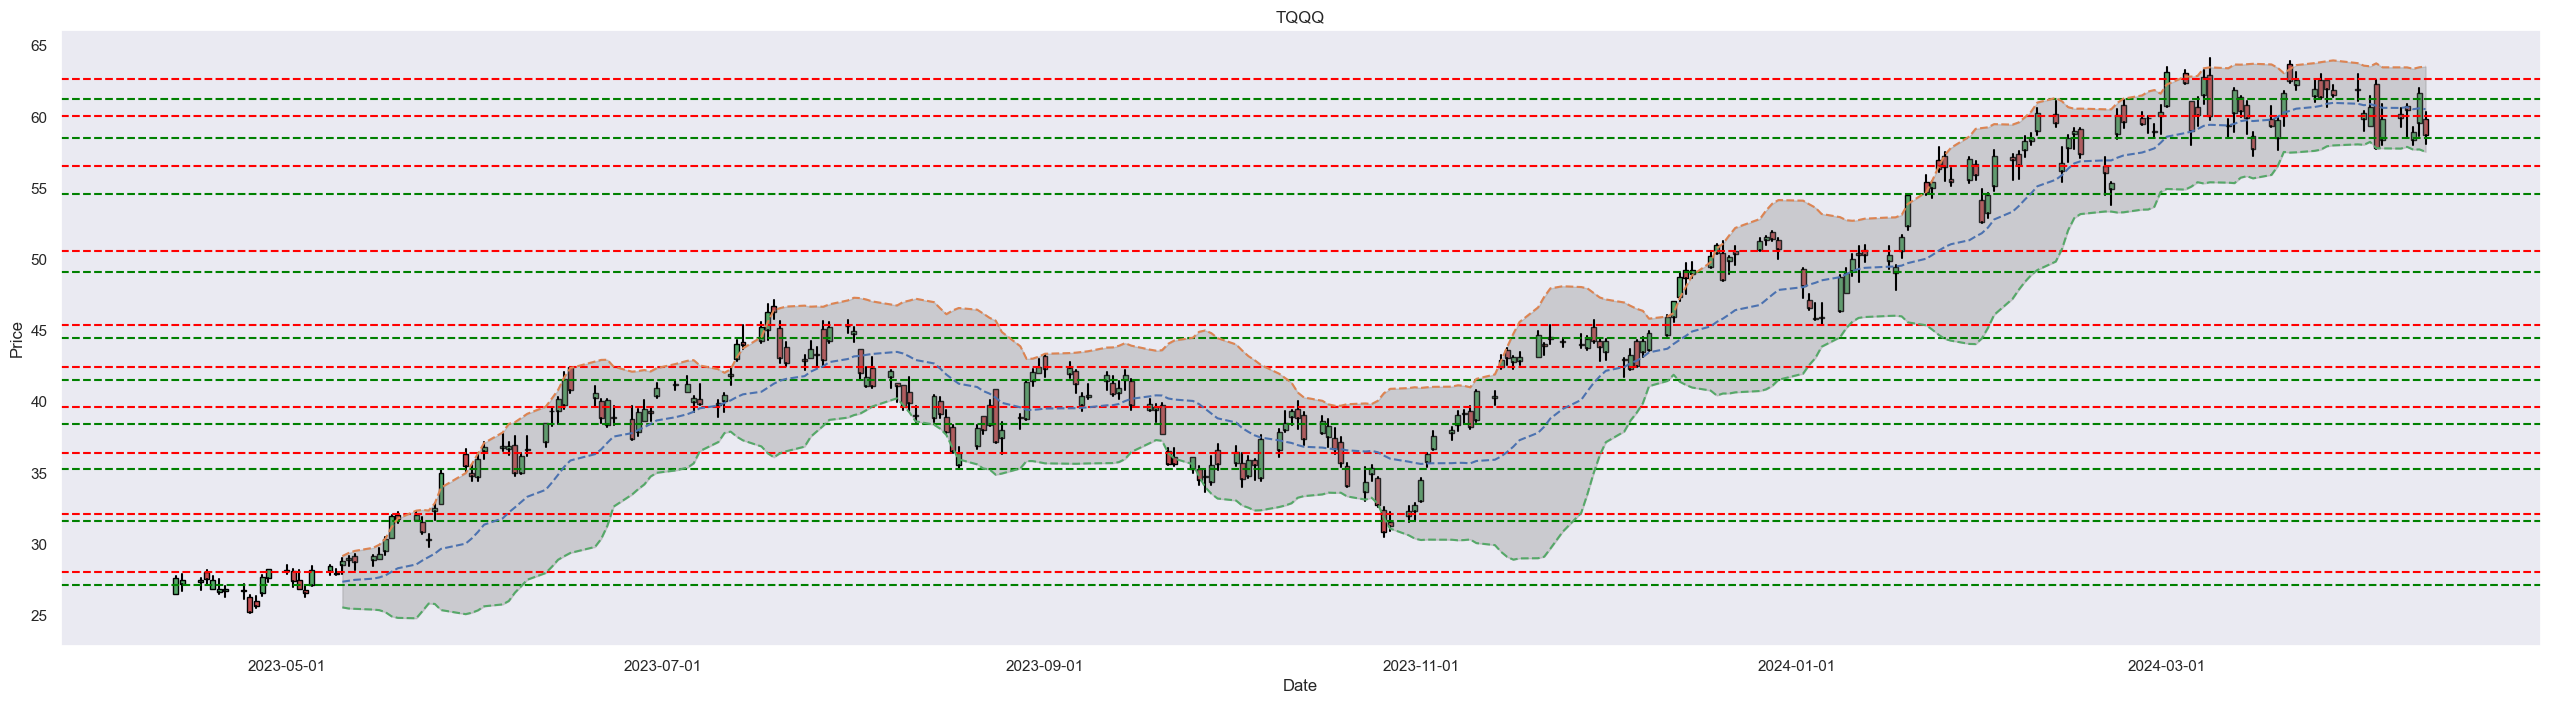

In [5]:
test_option_trading('TQQQ')

SPY & UPRO

[*********************100%%**********************]  1 of 1 completed
2024-04-13
* previous stock price closing 510.85 ~ up 519.84 , down 508.85
Latest 20 Day MA: 518.001498413086
Latest Lower Bollinger Band: 510.0323918908263
Latest Higher Bollinger Band: 525.9706049353457
[[410.47628523]
 [422.23538325]
 [434.01166789]
 [444.1890308 ]
 [453.01942662]
 [470.99920166]
 [485.06777954]
 [494.95538095]
 [508.85181913]
 [518.1499939 ]]
[[414.91162109]
 [428.12538616]
 [437.77676302]
 [447.69256514]
 [456.90580602]
 [474.65583547]
 [488.05999756]
 [498.78076876]
 [510.41416677]
 [519.83707937]]


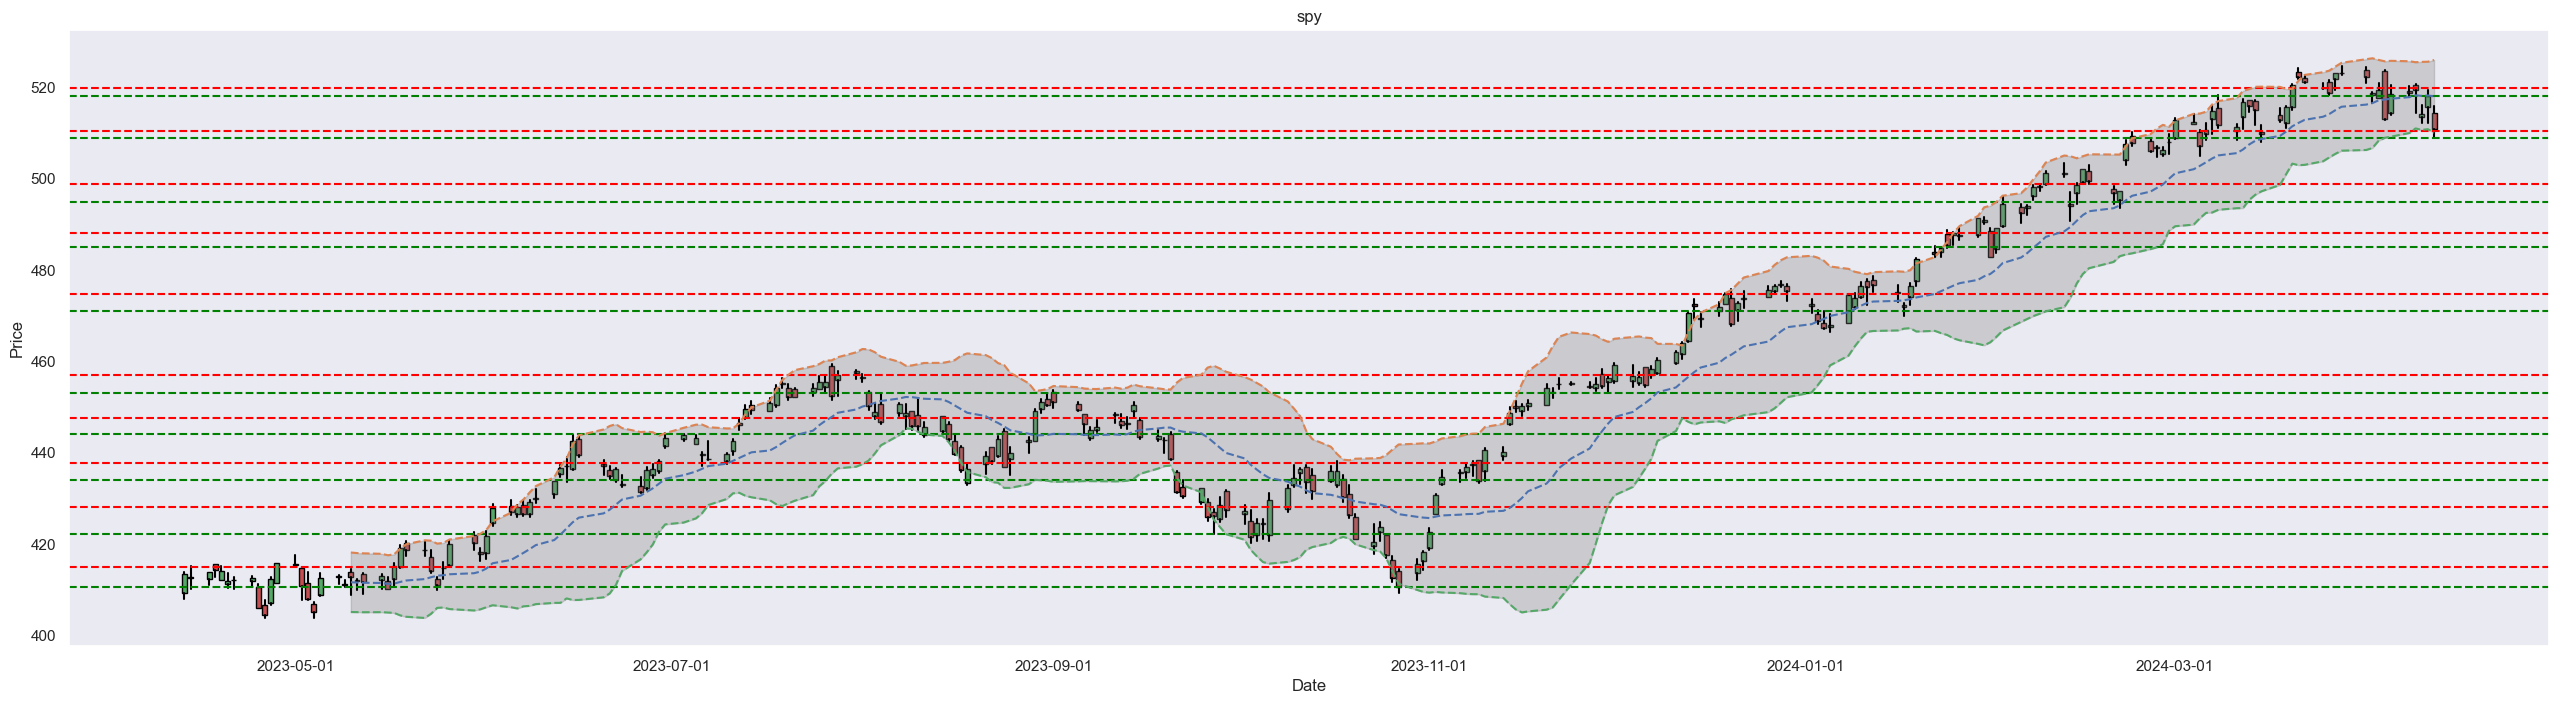

In [6]:
test_option_trading('spy')

[*********************100%%**********************]  1 of 1 completed
2024-04-13
* previous stock price closing 65.2 ~ up 66.09 , down 62.78
Latest 20 Day MA: 68.50049896240235
Latest Lower Bollinger Band: 65.27834086629156
Latest Higher Bollinger Band: 71.72265705851314
[[38.28499993]
 [41.8530307 ]
 [45.0721209 ]
 [47.54609764]
 [50.36133347]
 [53.49272693]
 [58.42250013]
 [62.78583336]
 [65.82499949]
 [69.0345452 ]]
[[39.3900001 ]
 [42.93545474]
 [45.97793106]
 [48.27476184]
 [50.76842117]
 [54.46416696]
 [58.58199997]
 [61.97615403]
 [66.08642796]
 [69.39227295]]


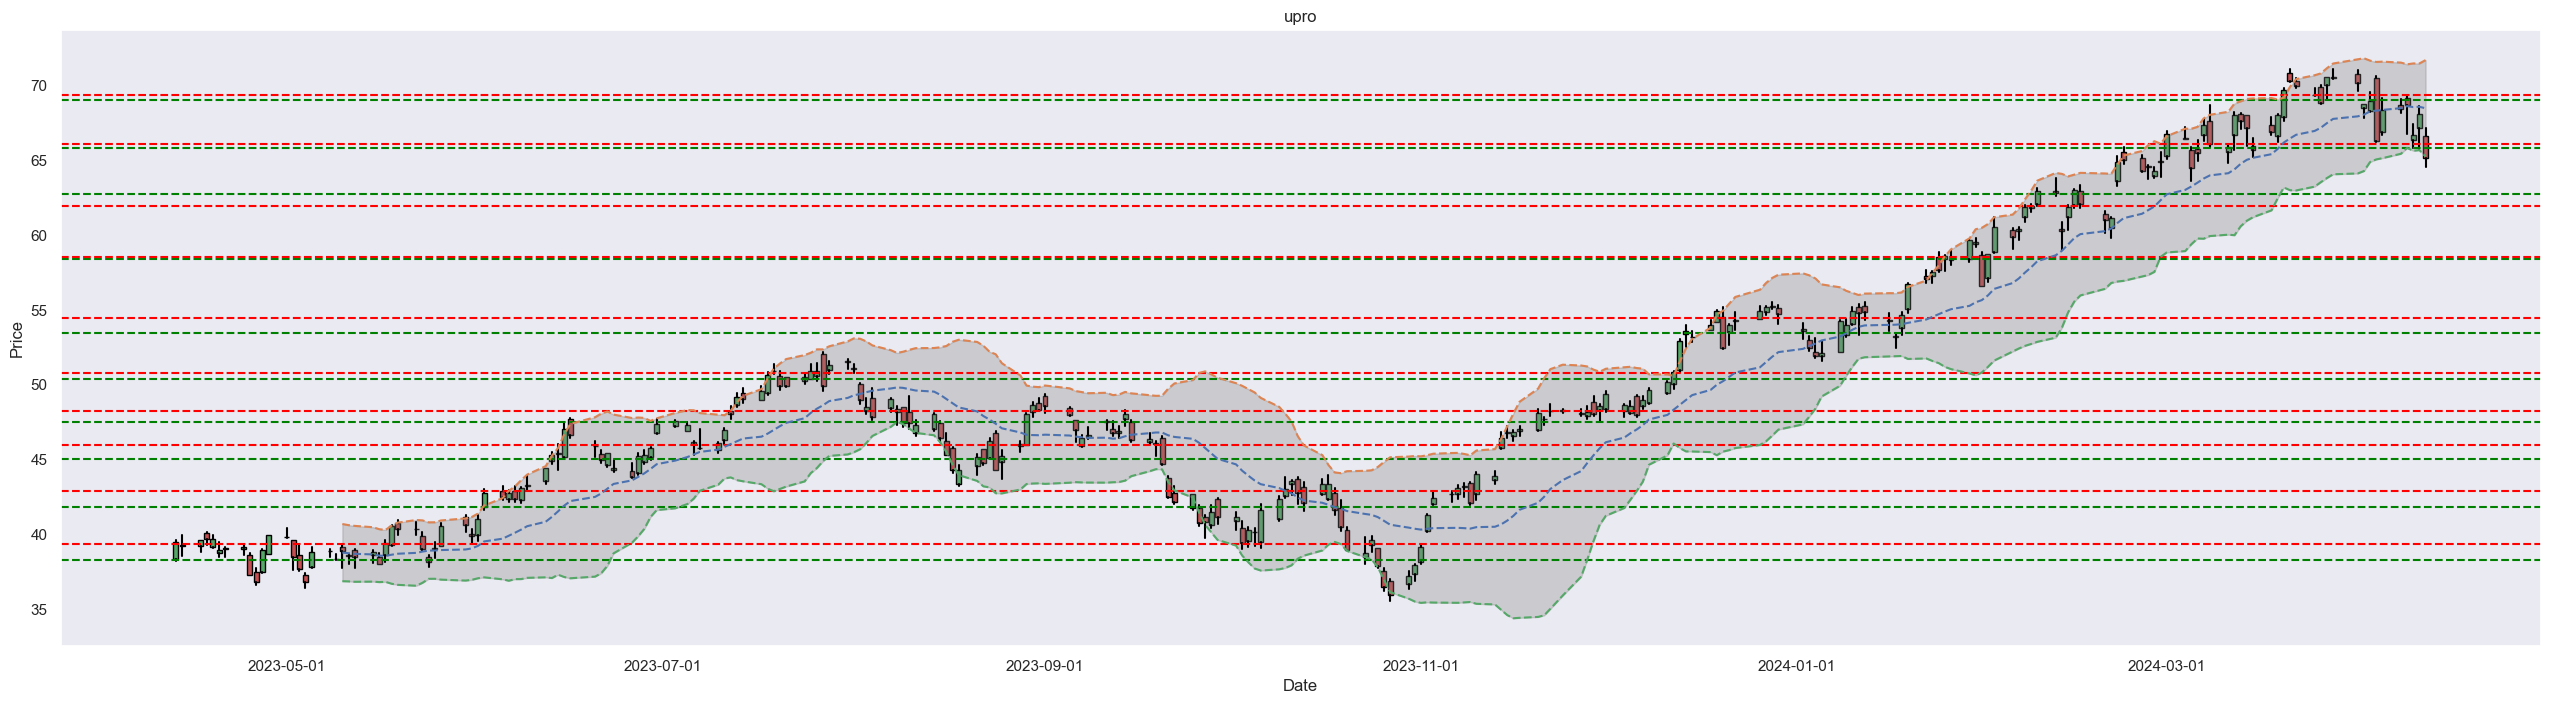

In [7]:
test_option_trading('upro')

SOXX & SOXL

[*********************100%%**********************]  1 of 1 completed
2024-04-13
* previous stock price closing 218.07 ~ up 227.97 , down 211.08
Latest 20 Day MA: 222.71049957275392
Latest Lower Bollinger Band: 216.1456663166169
Latest Higher Bollinger Band: 229.27533282889092
[[136.75874964]
 [146.05472056]
 [156.01120461]
 [162.29016337]
 [169.80449007]
 [181.33333435]
 [191.25666809]
 [200.49066569]
 [211.08333333]
 [222.21036897]]
[[139.67640015]
 [150.28513043]
 [159.11533356]
 [165.28634048]
 [171.75579701]
 [179.51488953]
 [190.69550247]
 [204.40296258]
 [216.39794804]
 [227.96230668]]


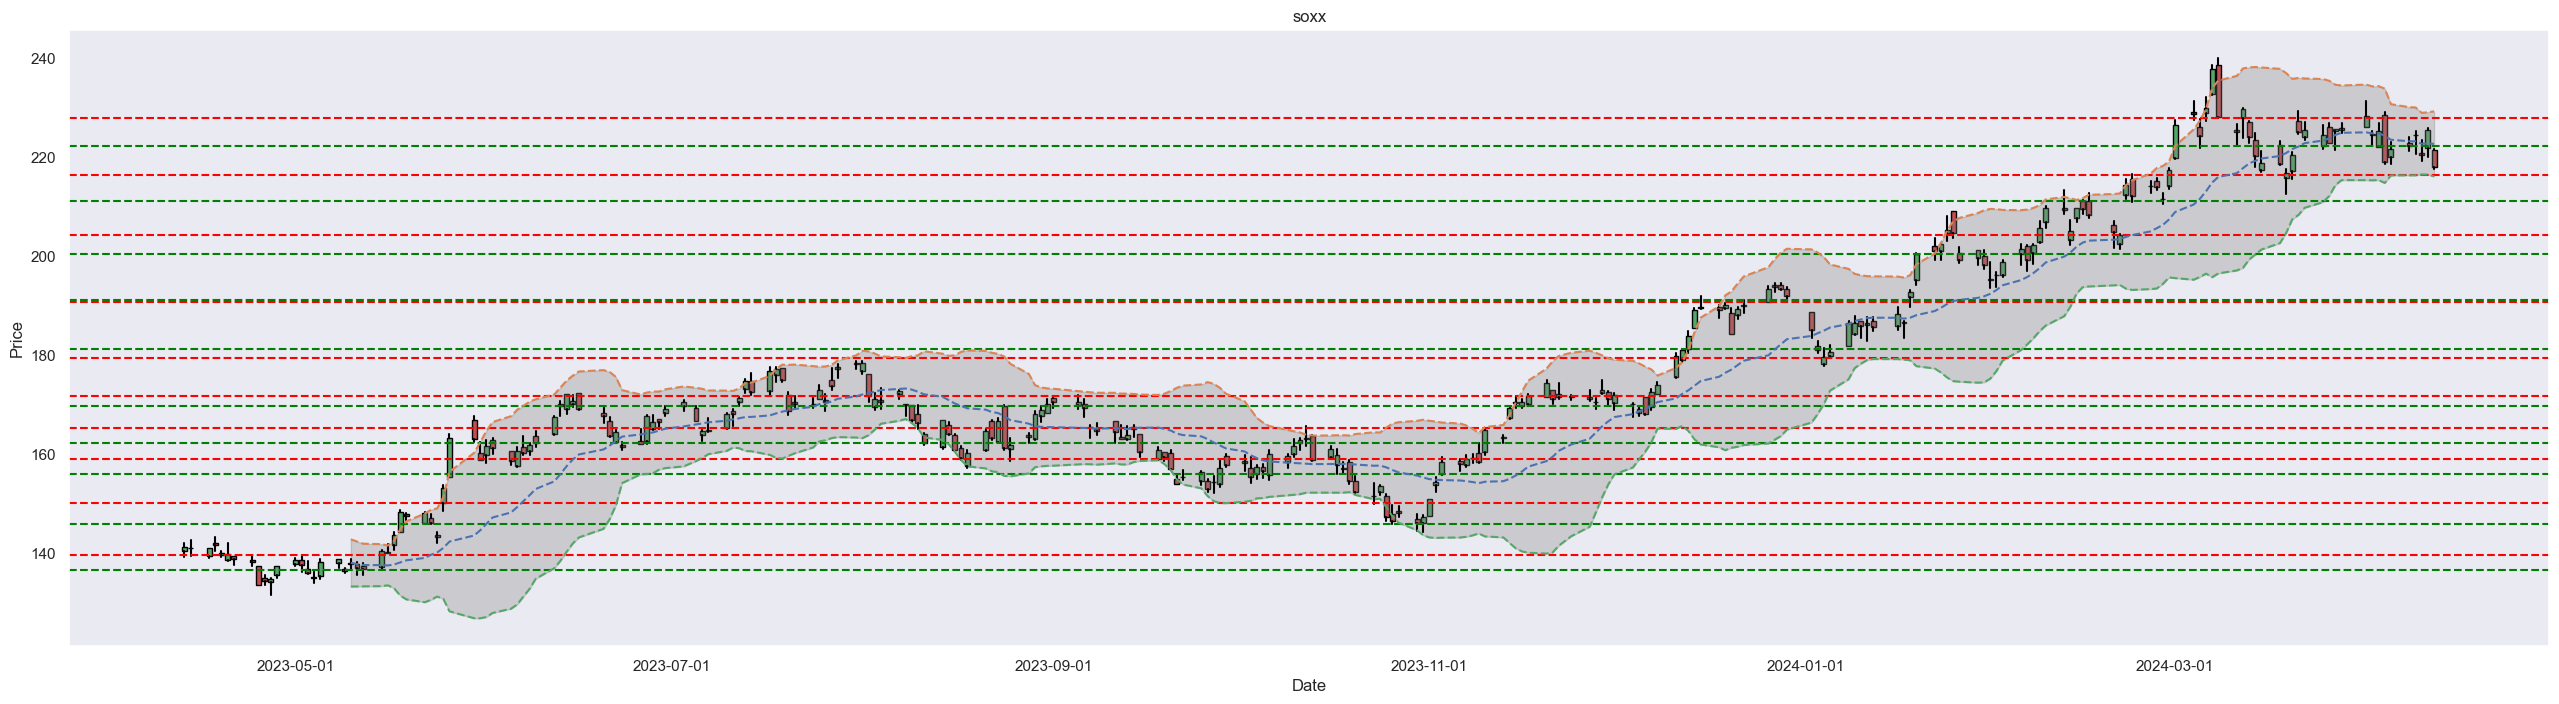

In [8]:
test_option_trading("soxx")

[*********************100%%**********************]  1 of 1 completed
2024-04-13
* previous stock price closing 41.51 ~ up 43.31 , down 40.57
Latest 20 Day MA: 44.6314998626709
Latest Lower Bollinger Band: 40.77794715219227
Latest Higher Bollinger Band: 48.48505257314953
[[14.29060607]
 [17.93175001]
 [21.27297872]
 [23.70684207]
 [26.7962501 ]
 [30.92733307]
 [34.87866643]
 [40.57894737]
 [44.86999989]
 [49.65499973]]
[[15.21612906]
 [19.12175002]
 [22.68086952]
 [25.30560987]
 [29.3592307 ]
 [34.5299999 ]
 [39.2239994 ]
 [43.30999974]
 [47.67666668]
 [54.07750034]]


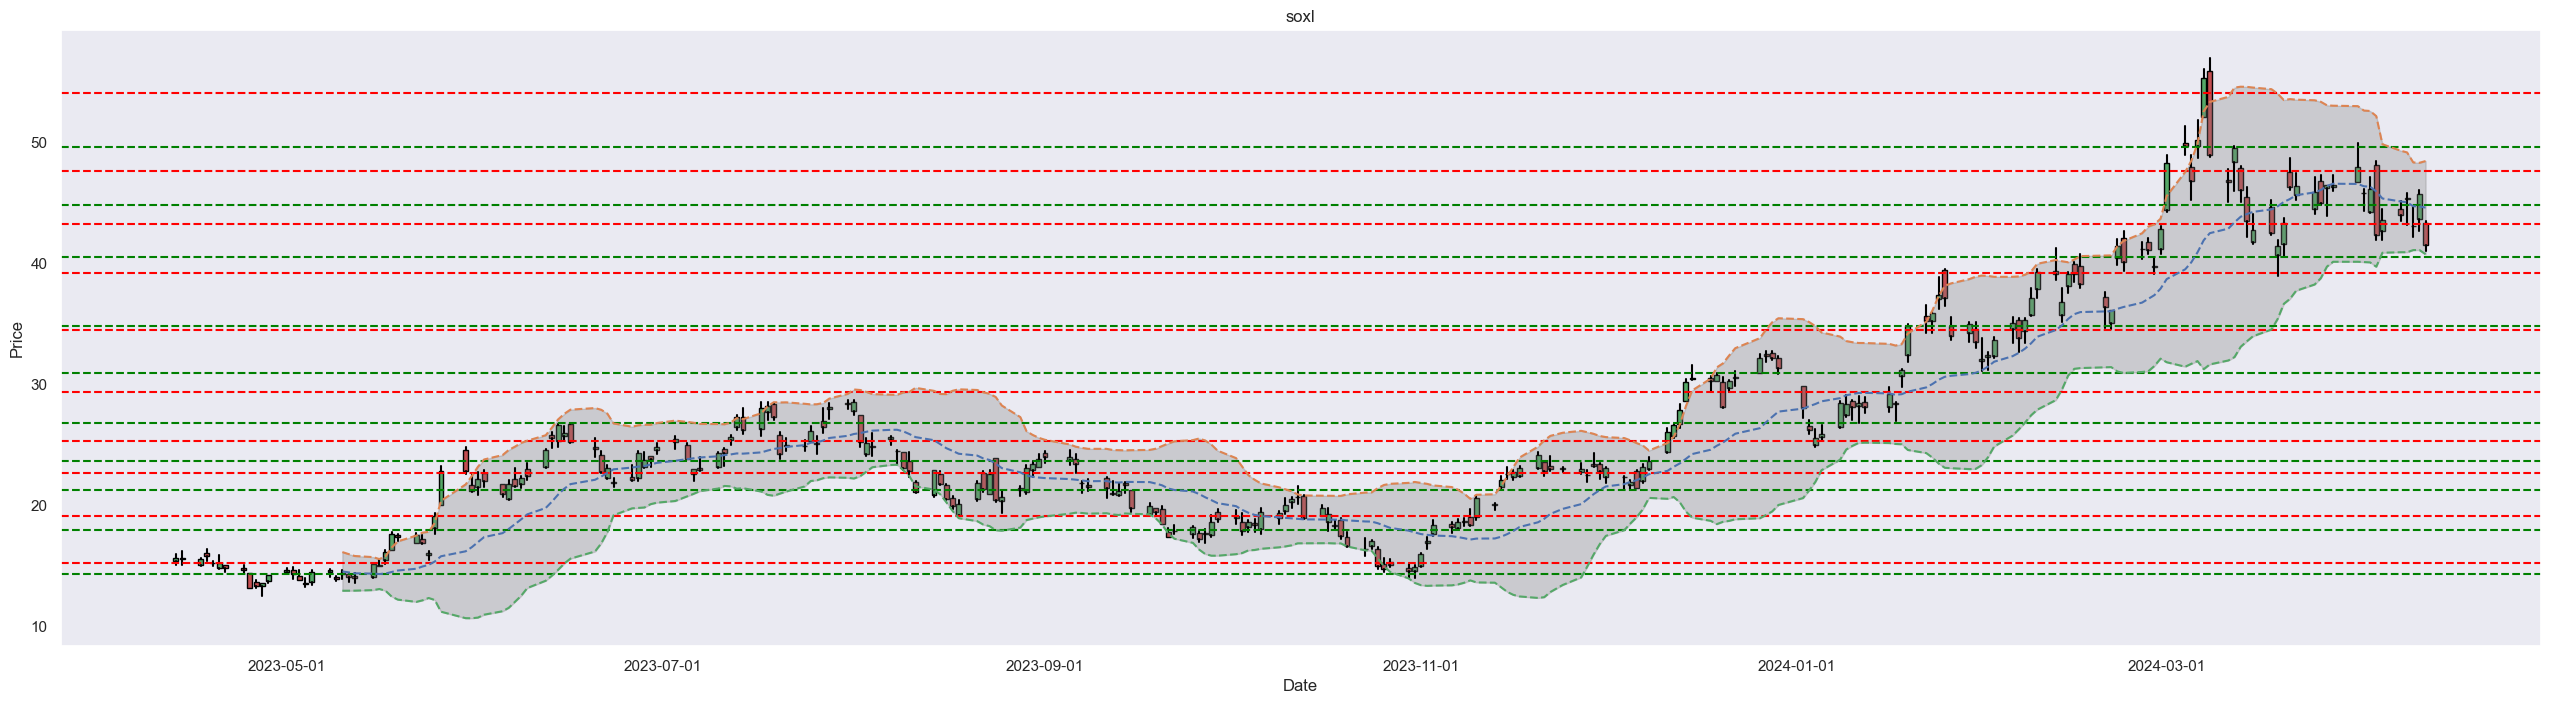

In [9]:
test_option_trading("soxl")

NVDA & NVDL

[*********************100%%**********************]  1 of 1 completed
2024-04-13
* previous stock price closing 881.86 ~ up 895.07 , down 857.38
Latest 20 Day MA: 895.4874969482422
Latest Lower Bollinger Band: 845.1828222601466
Latest Higher Bollinger Band: 945.7921716363378
[[279.73866374]
 [405.95245073]
 [444.92245323]
 [479.22113731]
 [545.05125427]
 [608.22299805]
 [693.71916707]
 [774.80999756]
 [857.38055081]
 [899.4827215 ]]
[[287.68899841]
 [422.95152567]
 [461.48823398]
 [492.19844428]
 [557.35286168]
 [622.8490878 ]
 [719.97332764]
 [803.31143624]
 [895.06578626]
 [940.56399536]]


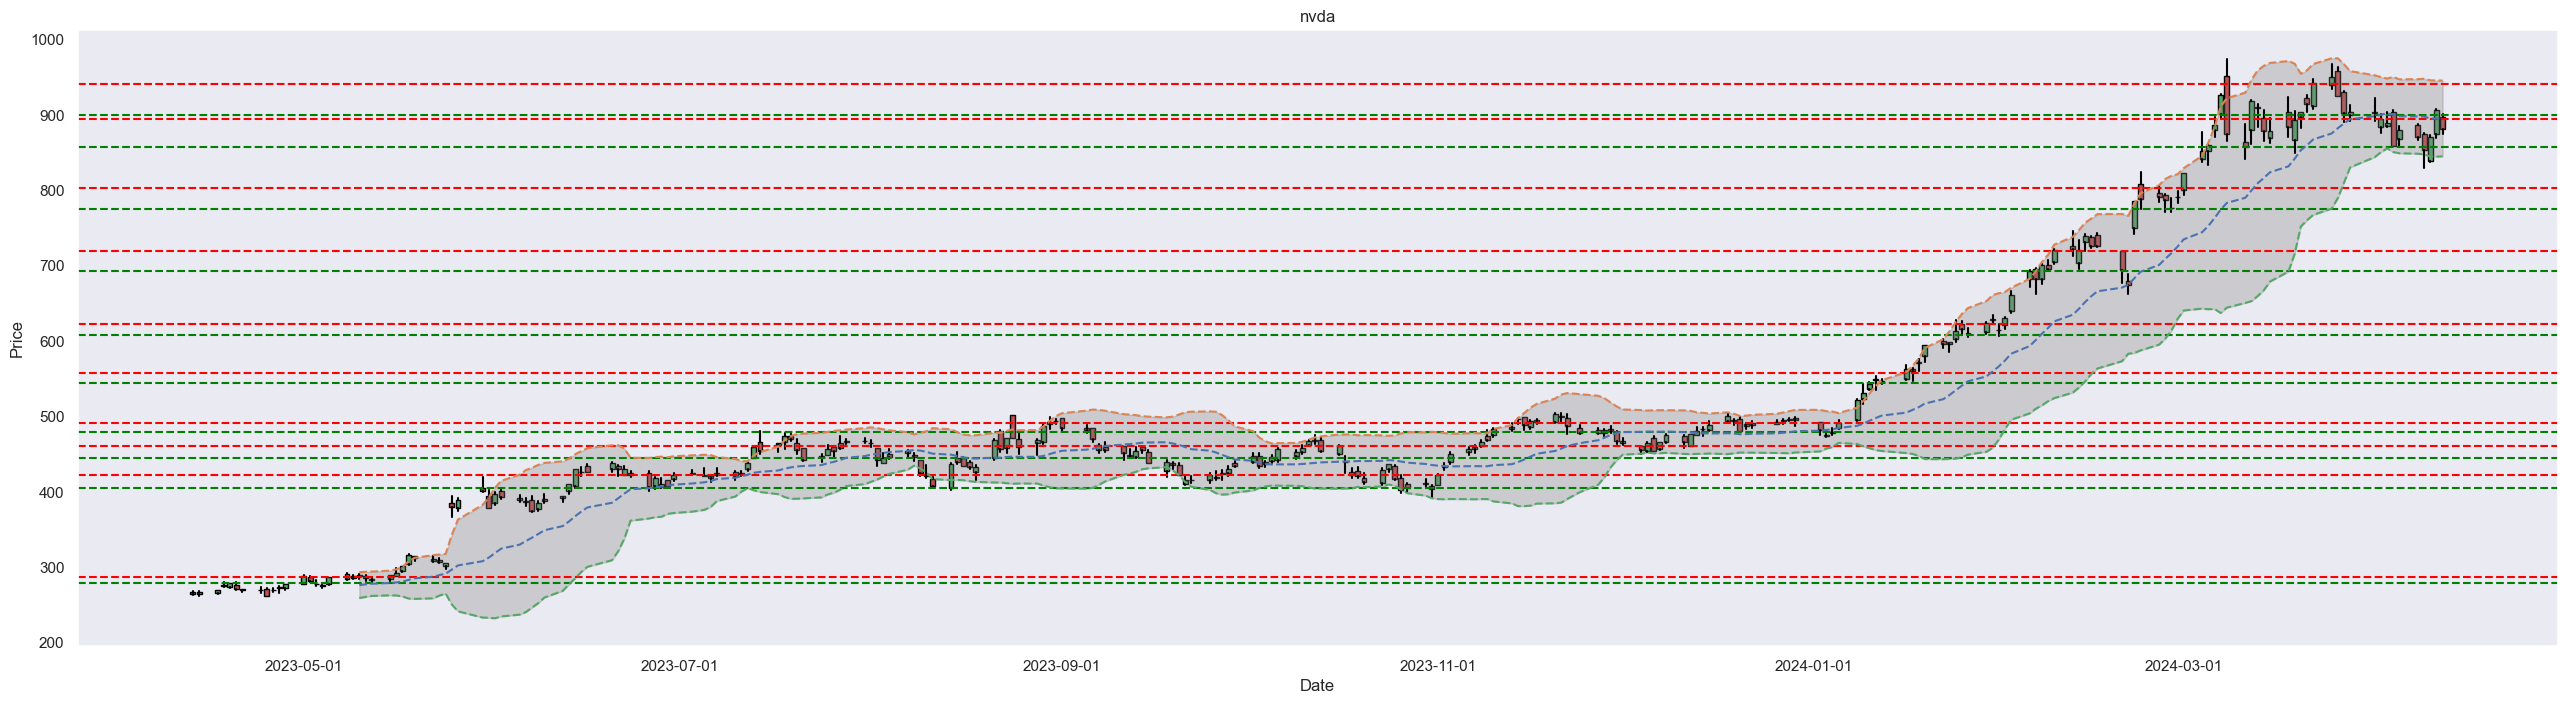

In [10]:
test_option_trading('nvda')

[*********************100%%**********************]  1 of 1 completed
2024-04-13
* previous stock price closing 39.22 ~ up 39.34 , down 37.79
Latest 20 Day MA: 40.89050006866455
Latest Lower Bollinger Band: 36.024924068286225
Latest Higher Bollinger Band: 45.75607606904288
[[ 7.86575006]
 [12.82145924]
 [14.52390299]
 [16.17698553]
 [19.93965034]
 [23.97666645]
 [27.63852024]
 [32.39659555]
 [37.79937482]
 [41.30197175]]
[[ 8.21957993]
 [13.4457026 ]
 [14.9799248 ]
 [16.76150004]
 [21.47888904]
 [28.11618074]
 [33.87278639]
 [39.33166695]
 [42.40462028]
 [47.64100075]]


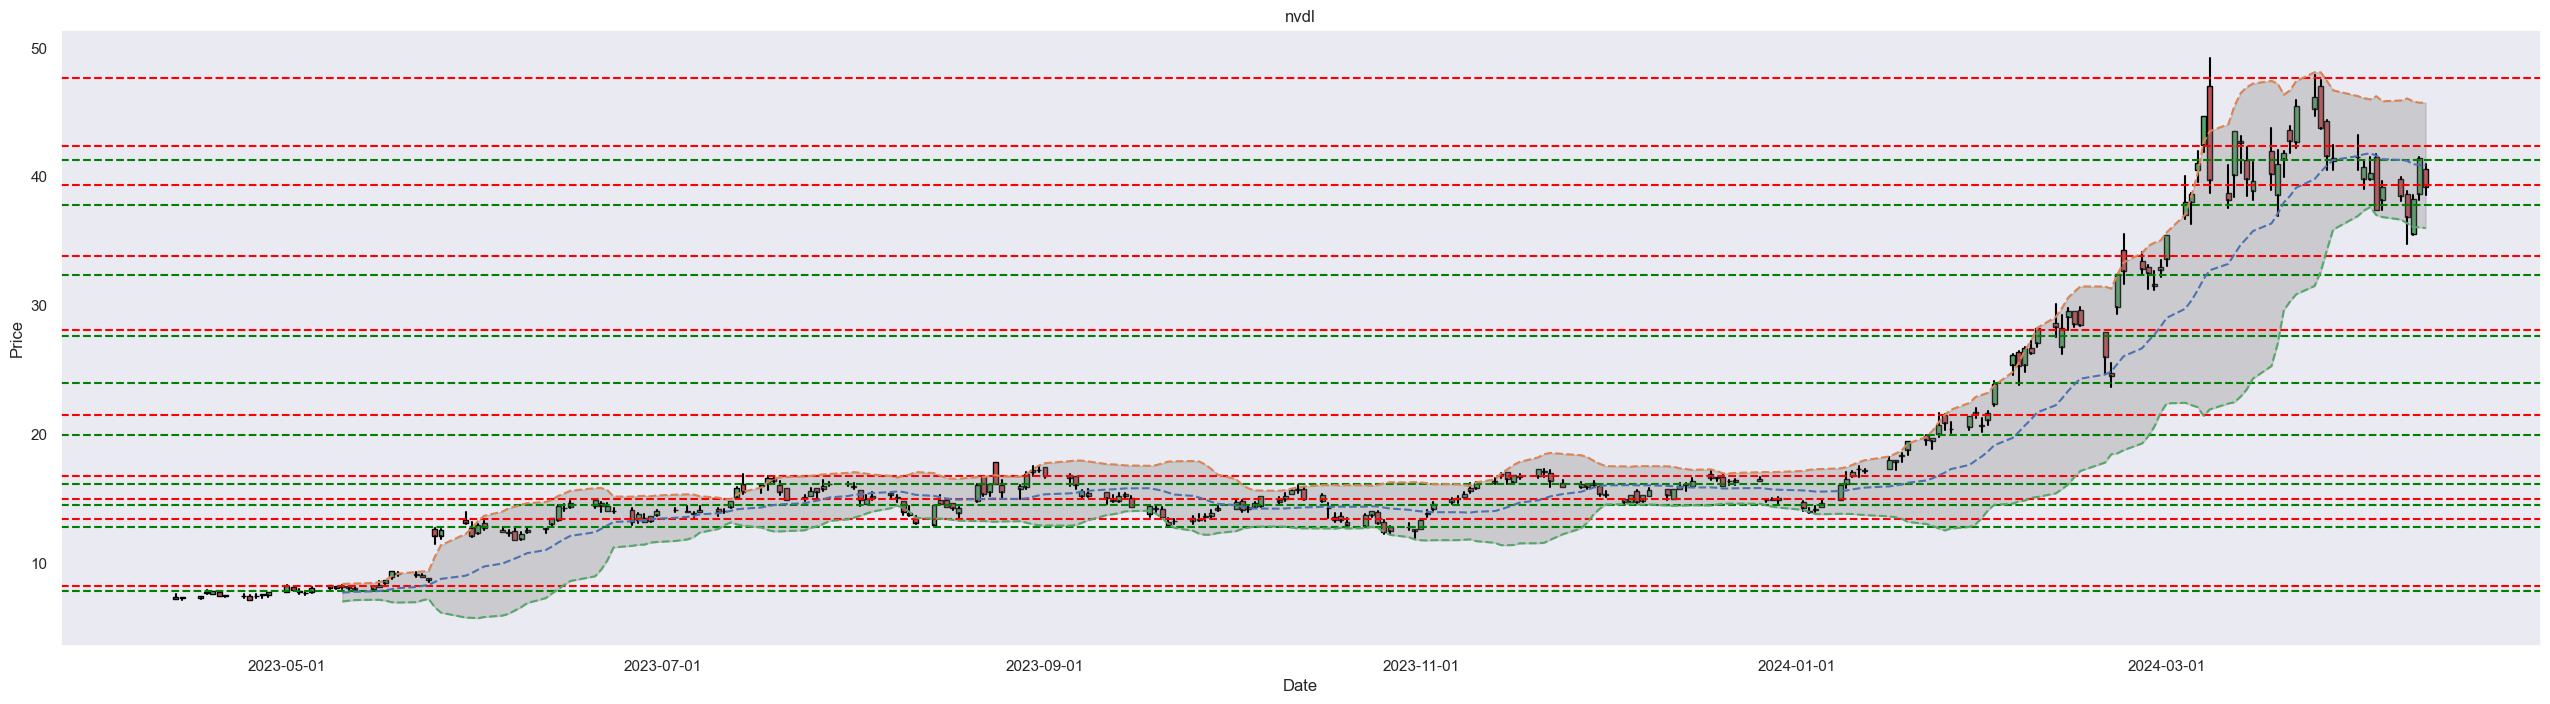

In [11]:
test_option_trading("nvdl")

Gld & UGL

[*********************100%%**********************]  1 of 1 completed
2024-04-13
* previous stock price closing 216.89 ~ up 219.68 , down 215.52
Latest 20 Day MA: 208.00250167846679
Latest Lower Bollinger Band: 193.61783070514326
Latest Higher Bollinger Band: 222.3871726517903
[[169.41428702]
 [174.1881811 ]
 [177.6619512 ]
 [180.740653  ]
 [183.69319185]
 [187.25686406]
 [189.85666826]
 [199.83117766]
 [209.63800049]
 [215.52999878]]
[[169.83600159]
 [174.7563643 ]
 [179.01264176]
 [182.88509683]
 [185.80266724]
 [188.60072798]
 [191.97875023]
 [201.6238895 ]
 [212.35599976]
 [219.67599792]]


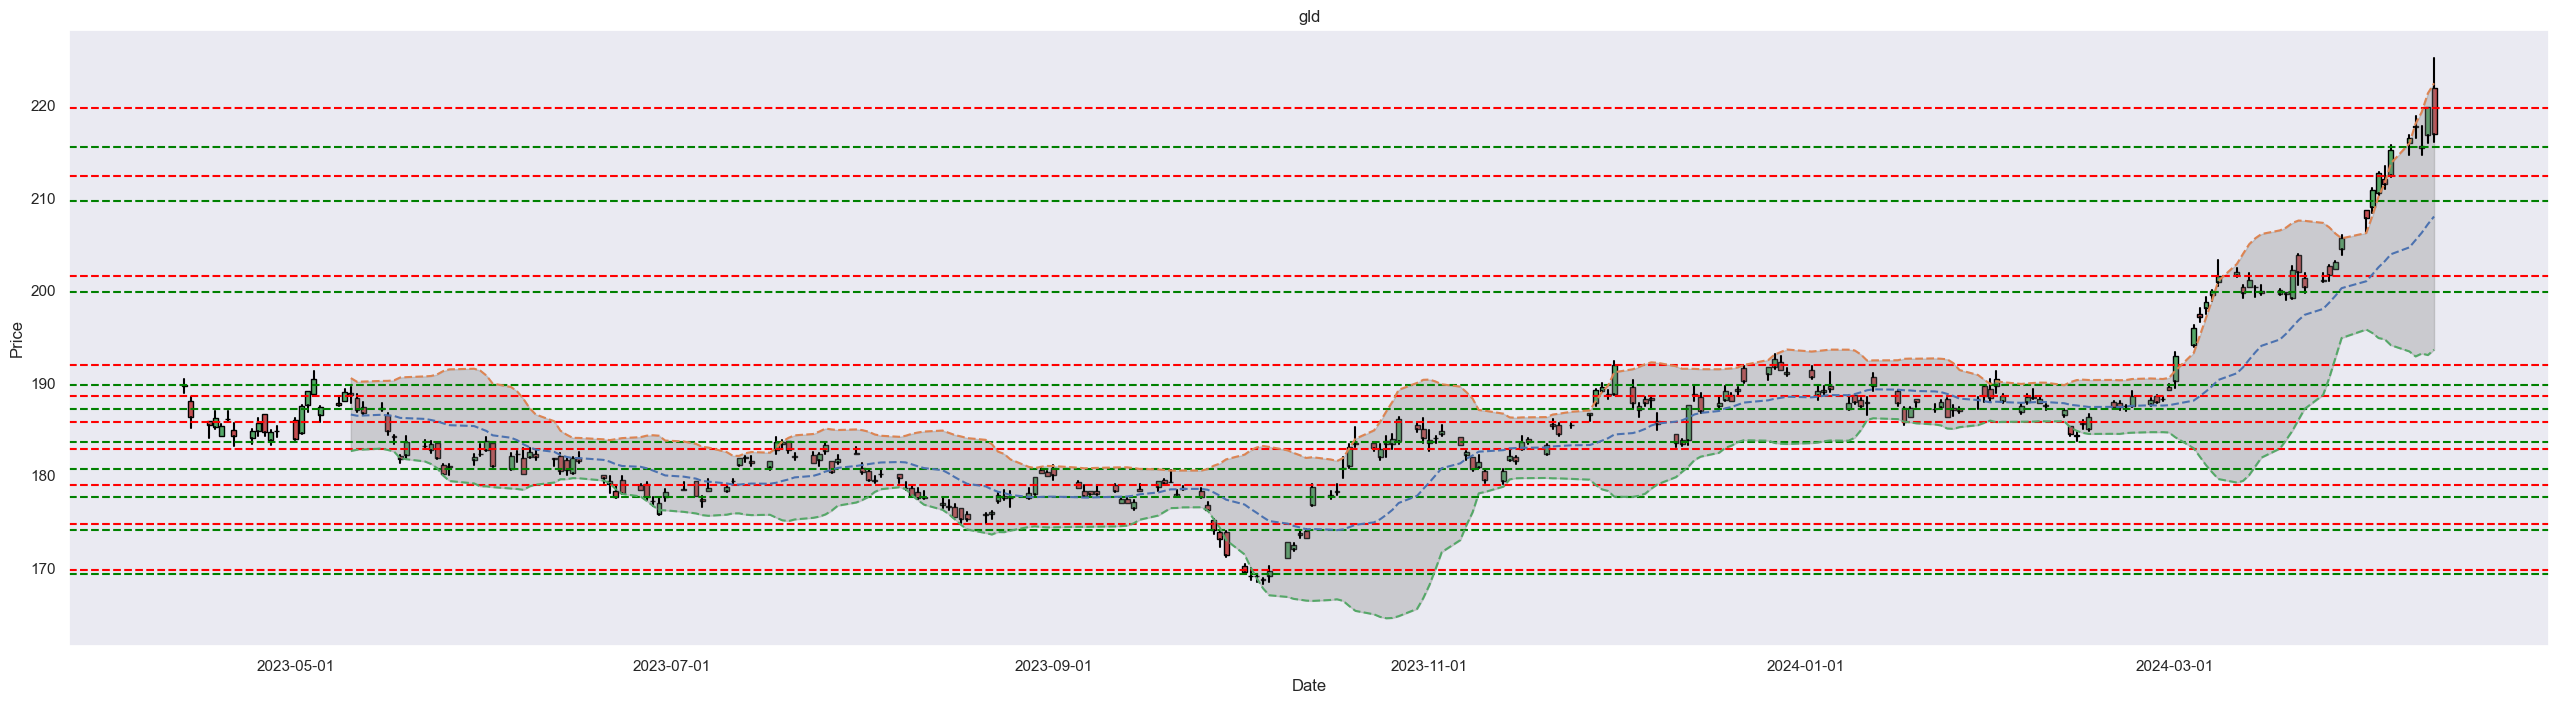

In [12]:
test_option_trading('gld')

[*********************100%%**********************]  1 of 1 completed
2024-04-13
* previous stock price closing 80.07 ~ up 81.69 , down 79.11
Latest 20 Day MA: 73.95000038146972
Latest Lower Bollinger Band: 64.04832061024563
Latest Higher Bollinger Band: 83.85168015269382
[[52.23416646]
 [56.60057155]
 [58.42275   ]
 [60.23810347]
 [61.57549973]
 [63.45772761]
 [65.6458327 ]
 [68.76875019]
 [75.01800079]
 [79.11199951]]
[[52.86636422]
 [57.3714704 ]
 [59.24578948]
 [61.11580627]
 [62.60931068]
 [64.78035736]
 [67.9371436 ]
 [70.54299927]
 [76.33500099]
 [81.68166478]]


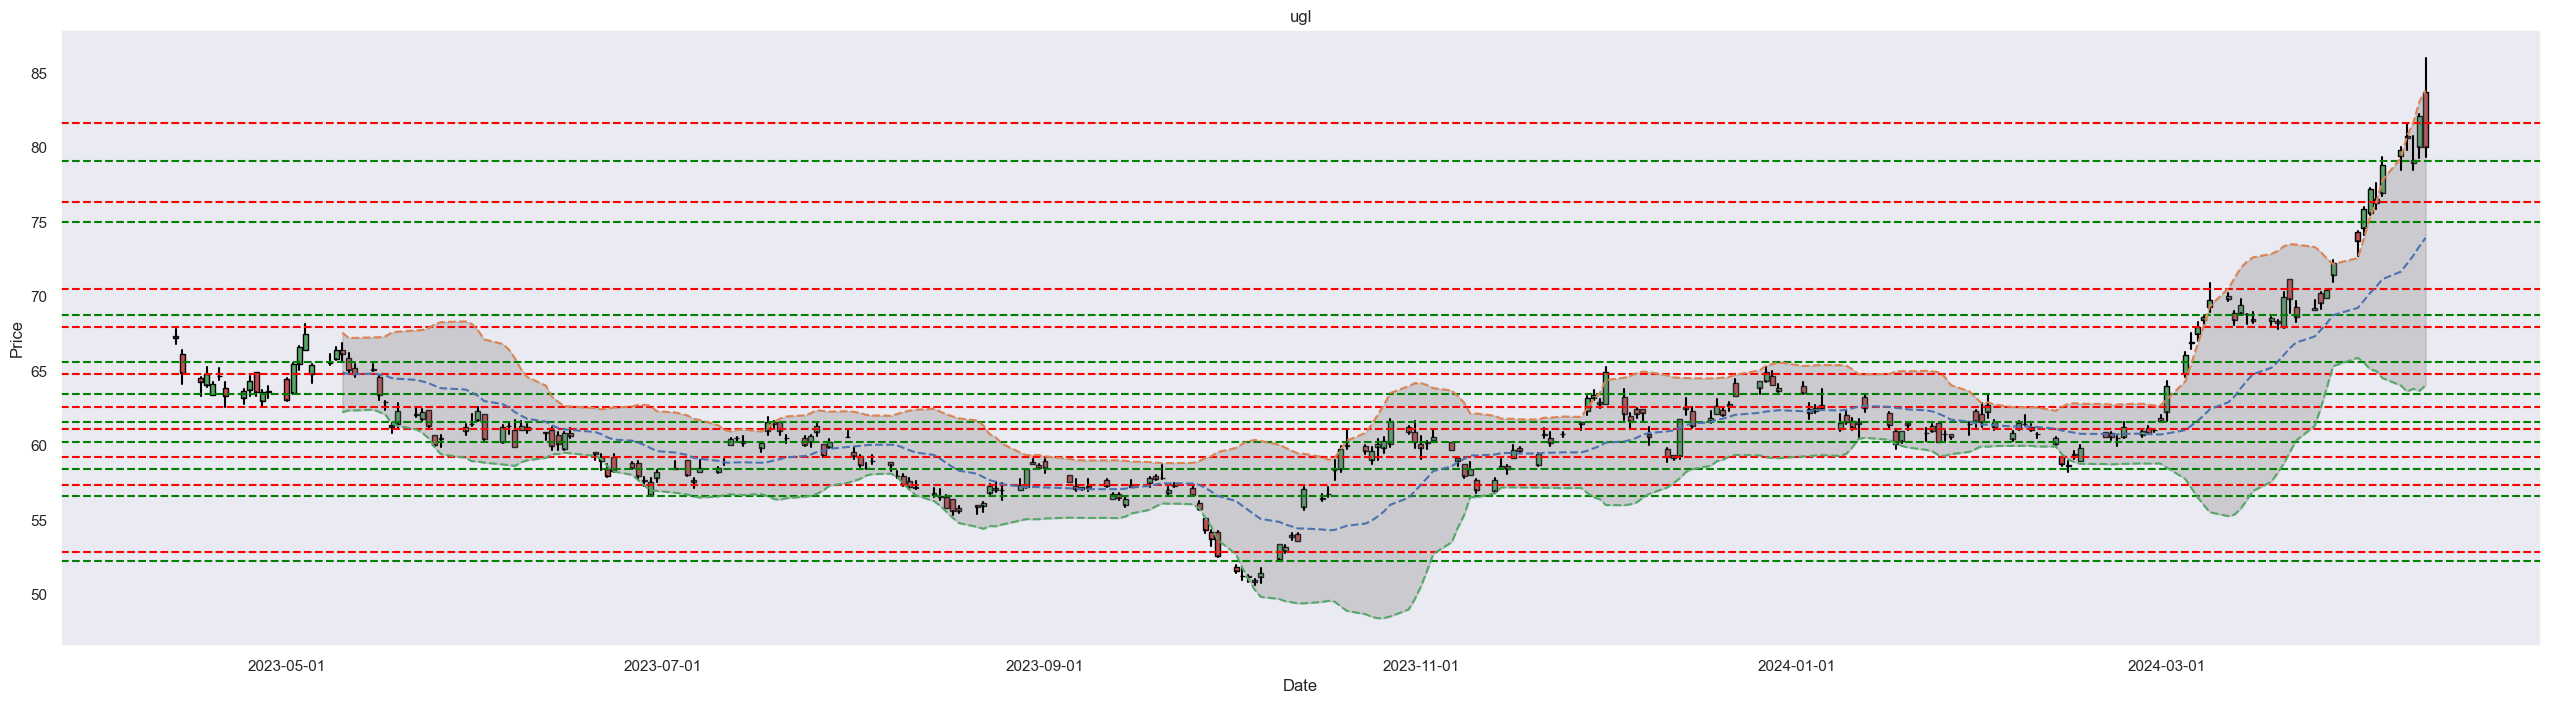

In [13]:
test_option_trading('ugl')

Random stocks

[*********************100%%**********************]  1 of 1 completed
2024-04-13
* previous stock price closing 171.05 ~ up 175.36 , down 170.09
Latest 20 Day MA: 172.37150192260742
Latest Lower Bollinger Band: 164.01535857666056
Latest Higher Bollinger Band: 180.72764526855428
[[160.015262  ]
 [170.09428406]
 [181.68963001]
 [194.85299911]
 [211.90535682]
 [230.9176651 ]
 [241.00968647]
 [250.76030338]
 [261.27652243]
 [276.52083333]]
[[165.79294093]
 [175.35923063]
 [187.60666606]
 [202.65350266]
 [219.70481477]
 [239.43583383]
 [251.51310414]
 [261.47947291]
 [274.79954529]
 [290.03000387]]


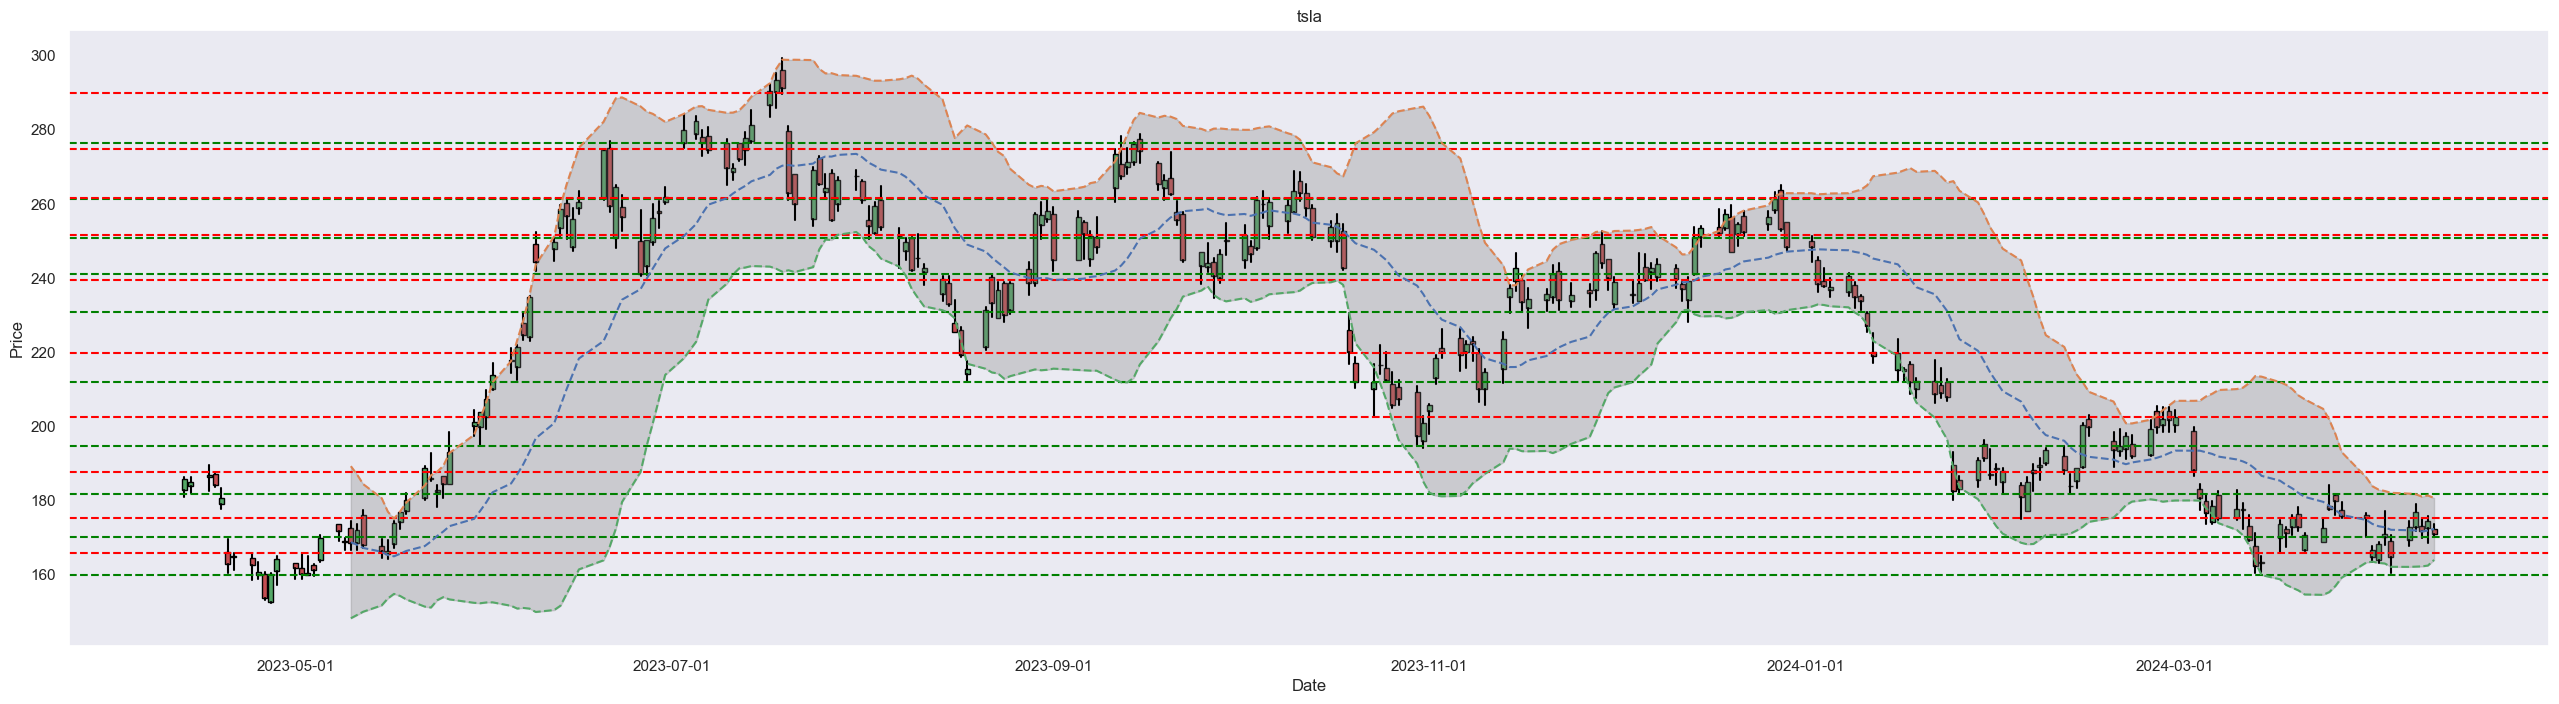

In [14]:
test_option_trading('tsla')

[*********************100%%**********************]  1 of 1 completed
2024-04-13
* previous stock price closing 67195.87 ~ up 69888.3 , down 60514.64
Latest 20 Day MA: 69130.1357421875
Latest Lower Bollinger Band: 65808.82157057787
Latest Higher Bollinger Band: 72451.44991379713
[[17907.78728966]
 [21854.99554802]
 [26674.19108711]
 [30125.65833162]
 [36195.74394914]
 [41953.72959808]
 [47549.30350889]
 [54660.37307363]
 [60514.64291487]
 [67246.43221507]]
[[17991.75136519]
 [22102.21221845]
 [27134.92108319]
 [30721.23537234]
 [37422.98413905]
 [42955.51036109]
 [49339.75806008]
 [57899.77996505]
 [62933.24549932]
 [69888.29208097]]


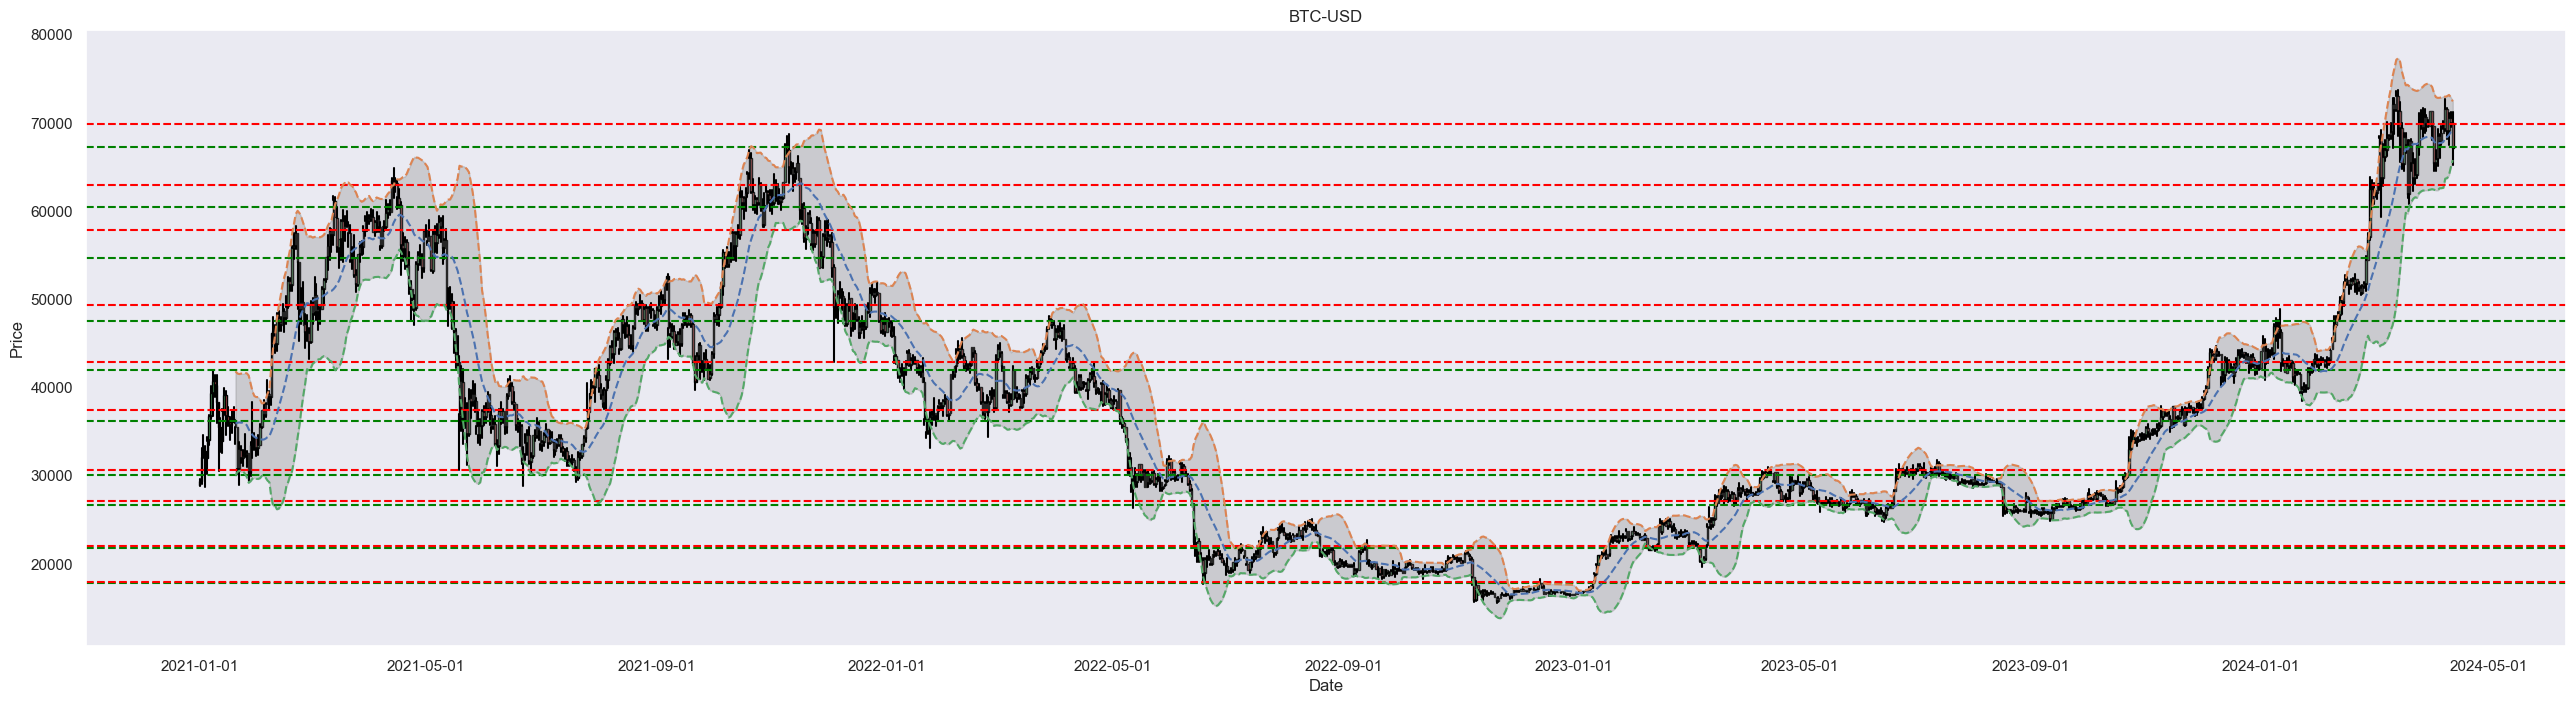

In [15]:
test_option_trading('BTC-USD', start='2021-01-01')